#**Revision and Transfer History**

12/18/25: Created and Worked in Colab

12/19/25: Added this Revision Tracker and Ran all in Colab - iPadOS - Duck Browser




# Political Alignment and Polarization

This is the second in a series of notebooks that make up a [case study in exploratory data analysis](https://allendowney.github.io/PoliticalAlignmentCaseStudy/).
This case study is part of the [*Elements of Data Science*](https://allendowney.github.io/ElementsOfDataScience/) curriculum.
[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/PoliticalAlignmentCaseStudy/blob/v1/02_partyid.ipynb).

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/v1/utils.py')

Downloaded utils.py


This chapter and the next make up a case study that uses data from the General Social Survey (GSS) to explore political beliefs and political alignment (conservative, moderate, or liberal) in the United States.
In this chapter, we will:

1. Compare the distributions of political alignment from 1974 and 2022.

2. Plot the mean and standard deviation of responses over time as a way of quantifying shifts in political alignment and polarization.

3. Use local regression to plot a smooth line through noisy data.

4. Use cross tabulation to compute the fraction of respondents in each category over time.

5. Plot the results using a custom color palette.

As an exercise, you will look at changes in political party affiliation over the same period.
In the next chapter, we'll use the same dataset to explore the relationship between political alignment and other attitudes and beliefs.

The following cell installs the `empiricaldist` library if necessary.

In [2]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.9.0-py3-none-any.whl size=14296 sha256=73f8ba17f20be062ea103be44a9c3c37912cc30ccede79b7276bf5f9bcdf0095
  Stored in directory: /root/.cache/pip/wheels/26/56/da/ea90b6b66dc5e72379a64e2819815066873f00c1350126e876
Successfully built empiricaldist


If everything we need is installed, the following cell should run without error.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Pmf

## Loading the data

In the previous notebook, we downloaded GSS data, loaded and cleaned it, resampled it to correct for stratified sampling, and then saved the data in an HDF file, which is much faster to load.  In this and the following notebooks, we'll download the HDF file and load it.

The following cell downloads the data file if necessary.

In [4]:
download(
    'https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/v1/gss_pacs_resampled.hdf'
)

Downloaded gss_pacs_resampled.hdf


We'll use an extract of the data that I have cleaned and resampled to correct for stratified sampling.
Instructions for downloading the file are in the notebook for this chapter.
It contains three resamplings -- we'll use the first, `gss0`, to get started.

In [5]:
datafile = 'gss_pacs_resampled.hdf'
gss = pd.read_hdf(datafile, key='gss0')
gss.shape

(72390, 207)

## Party Affiliation

The people surveyed for the GSS were asked about their "party affiliation", which is where they place themselves on a spectrum from Democcrat --> Independent --> Republucan.

See the Code Book for details.

They were asked:

> W????

Here is the scale they were shown:

| Code  | Response                 |
|-------|:-------------------------|
|   1   | Extremely liberal        |
|   2   | Liberal                  |
|   3   | Slightly liberal         |
|   4   | Moderate                 |
|   5   | Slightly conservative    |
|   6   | Conservative             |
|   7   | Extremely conservative   |




The variable `partyid` contains the responses.

In [6]:
partyid = gss['partyid']

To see how the responses have changed over time, we'll inspect them at the beginning and end of the observation period.
First we'll make a Boolean Series that's `True` for responses from 1974,
and select the responses from 1974.

In [7]:
year74 = (gss['year'] == 1974)
partyid74 = partyid[year74]

And we can do the same for 2022.

In [8]:
year22 = (gss['year'] == 2022)
partyid22 = partyid[year22]

We'll use the following function to count the number of times each response occurs.

In [9]:
def values(series):
    '''Count the values and sort.

    series: pd.Series

    returns: series mapping from values to frequencies
    '''
    return series.value_counts(dropna=False).sort_index()

Here are the responses from 1974.

In [10]:
values(partyid74)

,count
partyid,
0.0,273
1.0,394
2.0,173
3.0,130
4.0,102
5.0,203
6.0,112
7.0,68
NaN,29


And here are the responses from 2022.

In [11]:


values(partyid22)

,count
partyid,
0.0,519
1.0,473
2.0,352
3.0,742
4.0,424
5.0,362
6.0,491
7.0,124
NaN,57


Looking at these counts, we can get an idea of what the distributions look like, but in the next section we'll get a clearer picture by plotting them.

## Visualizing Distributions

To visualize these distributions, we'll use a Probability Mass Function (PMF), which is similar to a histogram, but there are two differences:

* In a histogram, values are often put in bins, with more than one value in each bin. In a PMF each value gets its own bin.

* A histogram computes a count, that is, how many times each value appears; a PMF computes a probability, that is, what fraction of the time each value appears.

We'll use the `Pmf` class from `empiricaldist` to compute a PMF.

In [12]:
from empiricaldist import Pmf

pmf74 = Pmf.from_seq(partyid74)
pmf74

,
partyid,
0.0,0.187629
1.0,0.270790
2.0,0.118900
3.0,0.089347
4.0,0.070103
5.0,0.139519
6.0,0.076976
7.0,0.046735


The following cell imports the function we'll use to decorate the axes in plots.

In [13]:
from utils import decorate

Here's the distribution from 1974:

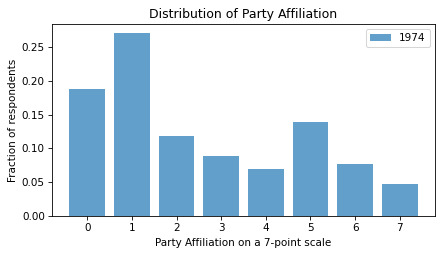

In [14]:
pmf74.bar(label='1974', color='C0', alpha=0.7)

decorate(
    xlabel='Party Affiliation on a 7-point scale',
    ylabel='Fraction of respondents',
    title='Distribution of Party Affiliation',
)

And from 2022:

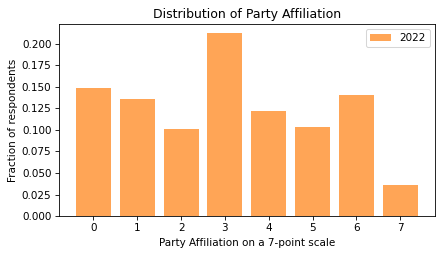

In [15]:
pmf22 = Pmf.from_seq(partyid22)
pmf22.bar(label='2022', color='C1', alpha=0.7)

decorate(
    xlabel='Party Affiliation on a 7-point scale',
    ylabel='Fraction of respondents',
    title='Distribution of Party Affiliation',
)

To make it easier to compare the distributions, I'll plot them side by side.  

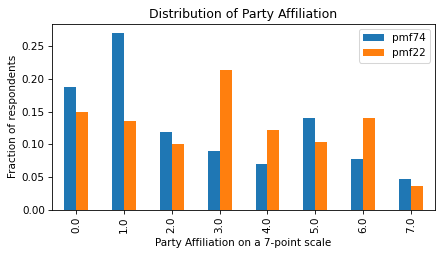

In [16]:
df = pd.DataFrame({'pmf74': pmf74, 'pmf22': pmf22})
df.plot(kind='bar')

decorate(
    xlabel='Party Affiliation on a 7-point scale',
    ylabel='Fraction of respondents',
    title='Distribution of Party Affiliation',
)

**Exercise:** To summarize these changes, we can compare the mean and standard deviation of `partyid` in 1974 and 2022.
The mean of the responses measures the balance of people in the population with liberal or conservative leanings.
If the mean increases over time, that might indicate a shift in the population toward conservatism.
The standard deviation measures the dispersion of views in the population -- if it increases over time, that might indicate an increase in polarization.

Compute the mean and standard deviation of `partyid74` and `partyid22`.
What do they indicate about changes over this interval?

In [17]:
mean74 = partyid74.mean()
std74 = partyid74.std()
print('mean74: ', mean74)
print('std74: ', std74)

mean74:  2.5436426116838486
std74:  2.180471456623223


In [18]:
mean22 = partyid22.mean()
std22 = partyid22.std()
print('mean22: ', mean22)
print('std22: ', std22)

mean22:  3.0751362202466304
std22:  2.086092674791437


In [19]:
mean74 = partyid74.mean()
std74 = partyid74.std()
print('mean74: ', round(mean74, 2))
print('std74: ', round(std74, 2))

mean74:  2.54
std74:  2.18


In [20]:
mean22 = partyid22.mean()
std22 = partyid22.std()
print('mean22: ', round(mean22, 2))
print('std22: ', round(std22, 2))

mean22:  3.08
std22:  2.09


## Interpretation ##
The Mean has increased indicating a shift toward conservatism. The Standard Deviation stayed almost
the same (decreasing slightly) indicating a shift, not a move to the extremes.

## Plotting a Time Series

At this point we have looked at the endpoints, 1974 and 2022, but we don't know what happened in between.
To see how the distribution changed over time, we can use `groupby` to group the respondents by year.

In [21]:
gss_by_year = gss.groupby('year')
type(gss_by_year)

pandas.core.groupby.generic.DataFrameGroupBy

The result is a `DataFrameGroupBy` object that represents a collection of groups.

We can loop through the groups and display the number of respondents in each:

In [22]:
for year, group in gss_by_year:
    print(year, len(group))

1972 1613
1973 1504
1974 1484
1975 1490
1976 1499
1977 1530
1978 1532
1980 1468
1982 1860
1983 1599
1984 1473
1985 1534
1986 1470
1987 1819
1988 1481
1989 1537
1990 1372
1991 1517
1993 1606
1994 2992
1996 2904
1998 2832
2000 2817
2002 2765
2004 2812
2006 4510
2008 2023
2010 2044
2012 1974
2014 2538
2016 2867
2018 2348
2021 4032
2022 3544


Now we can use the bracket operator to select the `partyid` column.

In [23]:
partyid_by_year = gss_by_year['partyid']
type(partyid_by_year)

pandas.core.groupby.generic.SeriesGroupBy

A column from a `DataFrameGroupBy` is a `SeriesGroupBy`.
If we invoke `mean` on it, the result is a series that contains the mean of `partyid` for each year of the survey.

In [24]:
mean_series = partyid_by_year.mean()

And here's what it looks like.

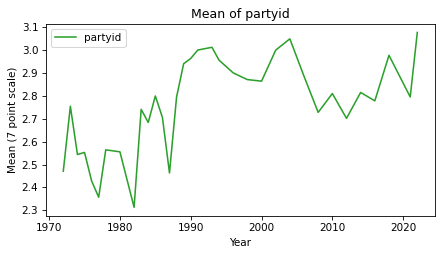

In [25]:
mean_series.plot(color='C2', label='partyid')
decorate(xlabel='Year',
         ylabel='Mean (7 point scale)',
         title='Mean of partyid')

The mean increased between 1974 and 1990, then yoh yoed since then.

In [26]:
mean_series.max() - mean_series.min()

0.7614213174388551

The upward (rightward) shift is almost a whole group (76%) when comparing minimums to maximums.

**Exercise:** The standard deviation quantifies the spread of the distribution, which is one way to measure polarization.
Plot standard deviation of `partyid` for each year of the survey from 1972 to 2022.
Does it show evidence of increasing polarization?

In [27]:
std_series = partyid_by_year.std()

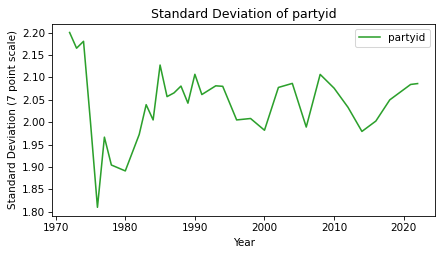

In [28]:
std_series.plot(color='C2', label='partyid')
decorate(xlabel='Year',
         ylabel='Standard Deviation (7 point scale)',
         title='Standard Deviation of partyid')

##**Polarization is Moderating**

As implied by a sharp decrease in Standard Deviation followed by moderation.




## Smoothing the Curve

In the previous section we plotted mean and standard deviation of `partyid` over time.
In both plots, the values are highly variable from year to year.
We can use **local regression** to compute a smooth line through these data points.  

The following function takes a Pandas `Series` and uses an algorithm called LOWESS to compute a smooth line.
LOWESS stands for 'locally weighted scatterplot smoothing'.

In [29]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    '''Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    '''
    y = series.values
    x = series.index.values

    smooth = lowess(y, x)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

We'll use the following function to plot data points and the smoothed line.

In [30]:
def plot_series_lowess(series, color):
    '''Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    '''
    series.plot(linewidth=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='', color=color)

The following figure shows the mean of `partyid` and a smooth line.

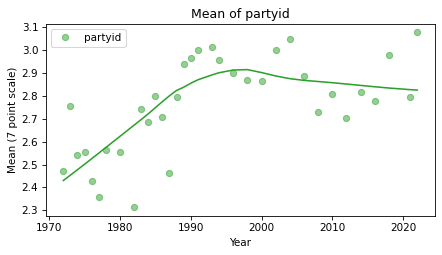

In [31]:
mean_series = gss_by_year['partyid'].mean()
plot_series_lowess(mean_series, 'C2')
decorate(xlabel='Year',
         ylabel='Mean (7 point scale)',
         title='Mean of partyid')

**Exercise:** Use `plot_series_lowess` to plot the standard deviation of `partyid` with a smooth line.

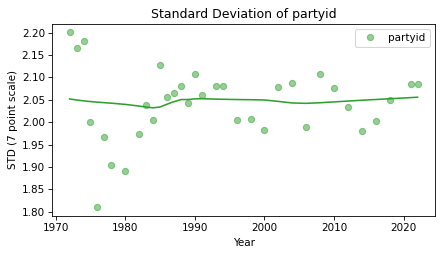

In [32]:
std_series = gss_by_year['partyid'].std()
plot_series_lowess(std_series, 'C2')
decorate(xlabel='Year',
         ylabel='STD (7 point scale)',
         title='Standard Deviation of partyid')

## Cross Tabulation

In the previous sections, we treated `partyid` as a numerical quantity, so we were able to compute means and standard deviations.
But the responses are really categorical, which means that each value represents a discrete category, like 'liberal' or 'conservative'.
In this section, we'll treat `partyid` as a categorical variable, compute the number of respondents in each category during each year, and plot changes over time.

Pandas provides a function called `crosstab` that computes a **cross tabulation**
Here's how we can use to compute the number of respondents in each category during each year.

In [33]:
year = gss['year']
column = gss['partyid']

xtab = pd.crosstab(year, column)

The result is a `DataFrame` with one row for each year and one column for each category.
Here are the first few rows.

In [34]:
xtab.head()

partyid,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
year,,,,,,,,
1972,341,448,147,146,84,250,132,59
1973,226,372,195,140,141,229,101,87
1974,273,394,173,130,102,203,112,68
1975,258,353,186,190,117,258,110,10
1976,205,397,236,241,131,202,81,3


The number of respondents varies from year to year.
To make meaningful comparisons over time, we need to normalize the results, which means computing for each year the *fraction* of respondents in each category, rather than the count.
`crosstab` takes an optional argument that normalizes each row.

In [35]:
xtab_norm = pd.crosstab(year, column, normalize='index')

Here's what that looks like for the 7-point scale.

In [36]:
xtab_norm.head()

partyid,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
year,,,,,,,,
1972,0.212197,0.278780,0.091475,0.090853,0.052271,0.155569,0.082141,0.036714
1973,0.151576,0.249497,0.130785,0.093897,0.094567,0.153588,0.067740,0.058350
1974,0.187629,0.270790,0.118900,0.089347,0.070103,0.139519,0.076976,0.046735
1975,0.174089,0.238192,0.125506,0.128205,0.078947,0.174089,0.074224,0.006748
1976,0.137032,0.265374,0.157754,0.161096,0.087567,0.135027,0.054144,0.002005


Looking at the numbers in the table, it's hard to see what's going on.
In the next section, we'll plot the results.

To make the results easier to interpret, I'm going to replace the numeric codes 1-7 with strings.  First I'll make a dictionary that maps from numbers to strings:

In [37]:
partyid_map = {
    0: 'Strong Democrat',
    1: 'Not Very Strong Democrat',
    2: 'Independent, Close to Democtat',
    3: 'Independent',
    4: 'Independent, Close to Republican',
    5: 'Not Very Strong Republican',
    6: 'Strong Republican',
    7: 'Other Party',
}

Then we can use the `replace` function like this:

In [38]:
partyid7 = gss['partyid'].replace(partyid_map)

We can use `values` to confirm that the values in `partyid7` are strings.

In [39]:
values(partyid7)

,count
partyid,
Independent,11510
"Independent, Close to Democtat",8376
"Independent, Close to Republican",6740
Not Very Strong Democrat,14360
Not Very Strong Republican,10875
Other Party,1307
Strong Democrat,11250
Strong Republican,7446
NaN,526


If we make the cross tabulation again, we can see that the column names are strings.

In [40]:
xtab_norm = pd.crosstab(year, partyid7, normalize='index')
xtab_norm.columns

Index(['Independent', 'Independent, Close to Democtat',
       'Independent, Close to Republican', 'Not Very Strong Democrat',
       'Not Very Strong Republican', 'Other Party', 'Strong Democrat',
       'Strong Republican'],
      dtype='object', name='partyid')

We are almost ready to plot the results, but first we need some colors.

## Color Palettes

To represent political views, we'll use a color palette from blue to purple to red.
Seaborn provides a variety of color palettes -- we'll start with this one, which includes shades of blue and red.
To represent moderates, we'll replace the middle color with purple.

[You can read more about Seaborn's color palettes here](https://seaborn.pydata.org/tutorial/color_palettes.html).

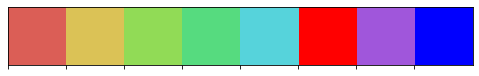

In [41]:
# palette = sns.color_palette('RdBu_r', 7)
palette = sns.color_palette("hls", 8)
# palette[3] = 'purple'
palette[7] = 'blue'
# palette[3] = 'green'
palette[5] = 'red'
sns.palplot(palette)

We'll make a dictionary that maps from the responses to the corresponding colors.

In [42]:
color_map = {}

for i, group in partyid_map.items():
    color_map[group] = palette[i-1]

In [43]:
for key, value in color_map.items():
    print(key, value)

Strong Democrat blue
Not Very Strong Democrat (0.86, 0.3712, 0.33999999999999997)
Independent, Close to Democtat (0.86, 0.7612000000000001, 0.33999999999999997)
Independent (0.5688000000000001, 0.86, 0.33999999999999997)
Independent, Close to Republican (0.33999999999999997, 0.86, 0.5012000000000001)
Not Very Strong Republican (0.33999999999999997, 0.8287999999999999, 0.86)
Strong Republican red
Other Party (0.6311999999999998, 0.33999999999999997, 0.86)


Now we're ready to plot.

## Plotting a Cross Tabulation

To see how the fraction of people with each party affiliation has changed over time,
we'll use `plot_series_lowess` to plot the columns from `xtab_norm`.
Here are the seven categories plotted as a function of time.
The `bbox_to_anchor` argument passed to `plt.legend` puts the legend outside the axes of the figure.

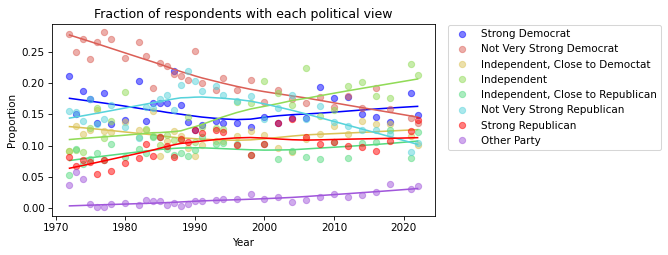

In [44]:
groups = list(partyid_map.values())

for group in groups:
    series = xtab_norm[group]
    plot_series_lowess(series, color_map[group])

decorate(
    xlabel='Year',
    ylabel='Proportion',
    title='Fraction of respondents with each political view',
)

plt.legend(bbox_to_anchor=(1.02, 1.02));

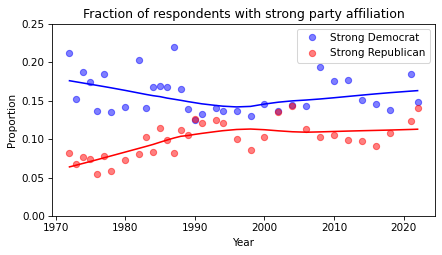

In [45]:
selected_groups = ['Strong Democrat', 'Strong Republican']

for group in selected_groups:
    series = xtab_norm[group]
    plot_series_lowess(series, color_map[group])

decorate(
    xlabel='Year',
    ylabel='Proportion',
    ylim=[0, 0.25],
    title='Fraction of respondents with strong party affiliation',
)



I used `ylim` to set the limits of the y-axis so it starts at zero, to avoid making the changes seem bigger than they are.
This figure shows that the fraction of people who describe themselves as 'extreme' has increased from about 2.5% to about 5%.
In relative terms, that's a big increase.
But in absolute terms these tails of the distribution are still small.

**Exercise:** Let's do a similar analysis with `partyid`, which encodes responses to the question:

>Generally speaking, do you usually think of yourself as a Republican, Democrat, Independent, or what?

The valid responses are:

| Code  | Response                |
|-------|:------------------------|
| 0     | Strong democrat         |
| 1     | Not str democrat        |
| 2     | Ind, near dem           |
| 3     | Independent             |
| 4     | Ind, near rep           |
| 5     | Not str republican      |
| 6     | Strong republican       |
| 7     | Other party             |

In the notebook for this chapter, there are some suggestions to get you started.

Here are the steps I suggest:

1) If you have not already saved this notebook, you should do that first.  If you are running on Colab, select 'Save a copy in Drive' from the File menu.

2) Now, before you modify this notebook, make *another* copy and give it an appropriate name.

3) Search and replace `partyid` with `partyid` (use 'Edit->Find and replace').

4) Run the notebook from the beginning and see what other changes you have to make.

What changes in party affiliation do you see over the last 50 years?  Are things going in the directions you expected?

## Summary

This chapter introduces two new tools: local regression for computing a smooth curve through noisy data, and cross tabulation for counting the number of people, or fraction, in each group over time.

Now that we have a sense of how political alignment as changed, in the next chapter we'll explore the relationship between political alignment and other beliefs and attitudes.

Political Alignment Case Study

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)